# Research paper related to oncology and COVID-19

## Outline:

* [Summary](#summary)
* [Strategy](#strategy)
* [Data processing](#data_processing)
* [Results](#results)
    - [Visualizations](#visualizations)
    - [research papers on oncology](#oncology)      

<a id="summary"></a>
## Summary:
Out of 48105 research papers available in the database, 4565 papers contain keywords related to COVID-19, within those only 98 papers contains keywords related to oncology 

### Top 10 research papers on oncology

In [ ]:
# load the file with the top results
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 150)
cancer_paper = pd.read_csv('../input/cancer-output/oncology_paper.csv')

cancer_paper[['cord_uid','title']].head(10)

<a id="strategy"></a>
## Strategy

This study takes advandage of the Phrasematcher from the NLP library Spacy, not only individual keywords, but also tokenized phrases can be use to find matched within a tokenized text. In this study, the abstract of the reseachers papers will be tokenized to be searched with custom defined keywords and search phrases.

* Oncology: 'oncology', 'cancer','biomarker','turnaround time','clinical lab'

* COVID-19: 'COVID-19', 'novel coronavirus 2019', '2019 novel coronavirus', 'new coronavirus pneumonia', 'SARS-CoV-2', 'coronavirus disease 2019'
            
As we are interested in the research papers related to the current COVID-19 outbreak, the papers with COVID-19 related will be first selected. The papers are ranked by the number of unique keywords and the the number of sub-topics found in the papers. 

It is possible that a paper can contain keywords/phrases in multiple sub-topics, which means that this paper covers a broad range of topic of our interest. On the other hand, it is possible that a paper contain multiple keywords or phrases within a particular sub-topics. The higher the number of unique keywords/phrases, the more likely that paper is relavant to the questions we are interested in. 

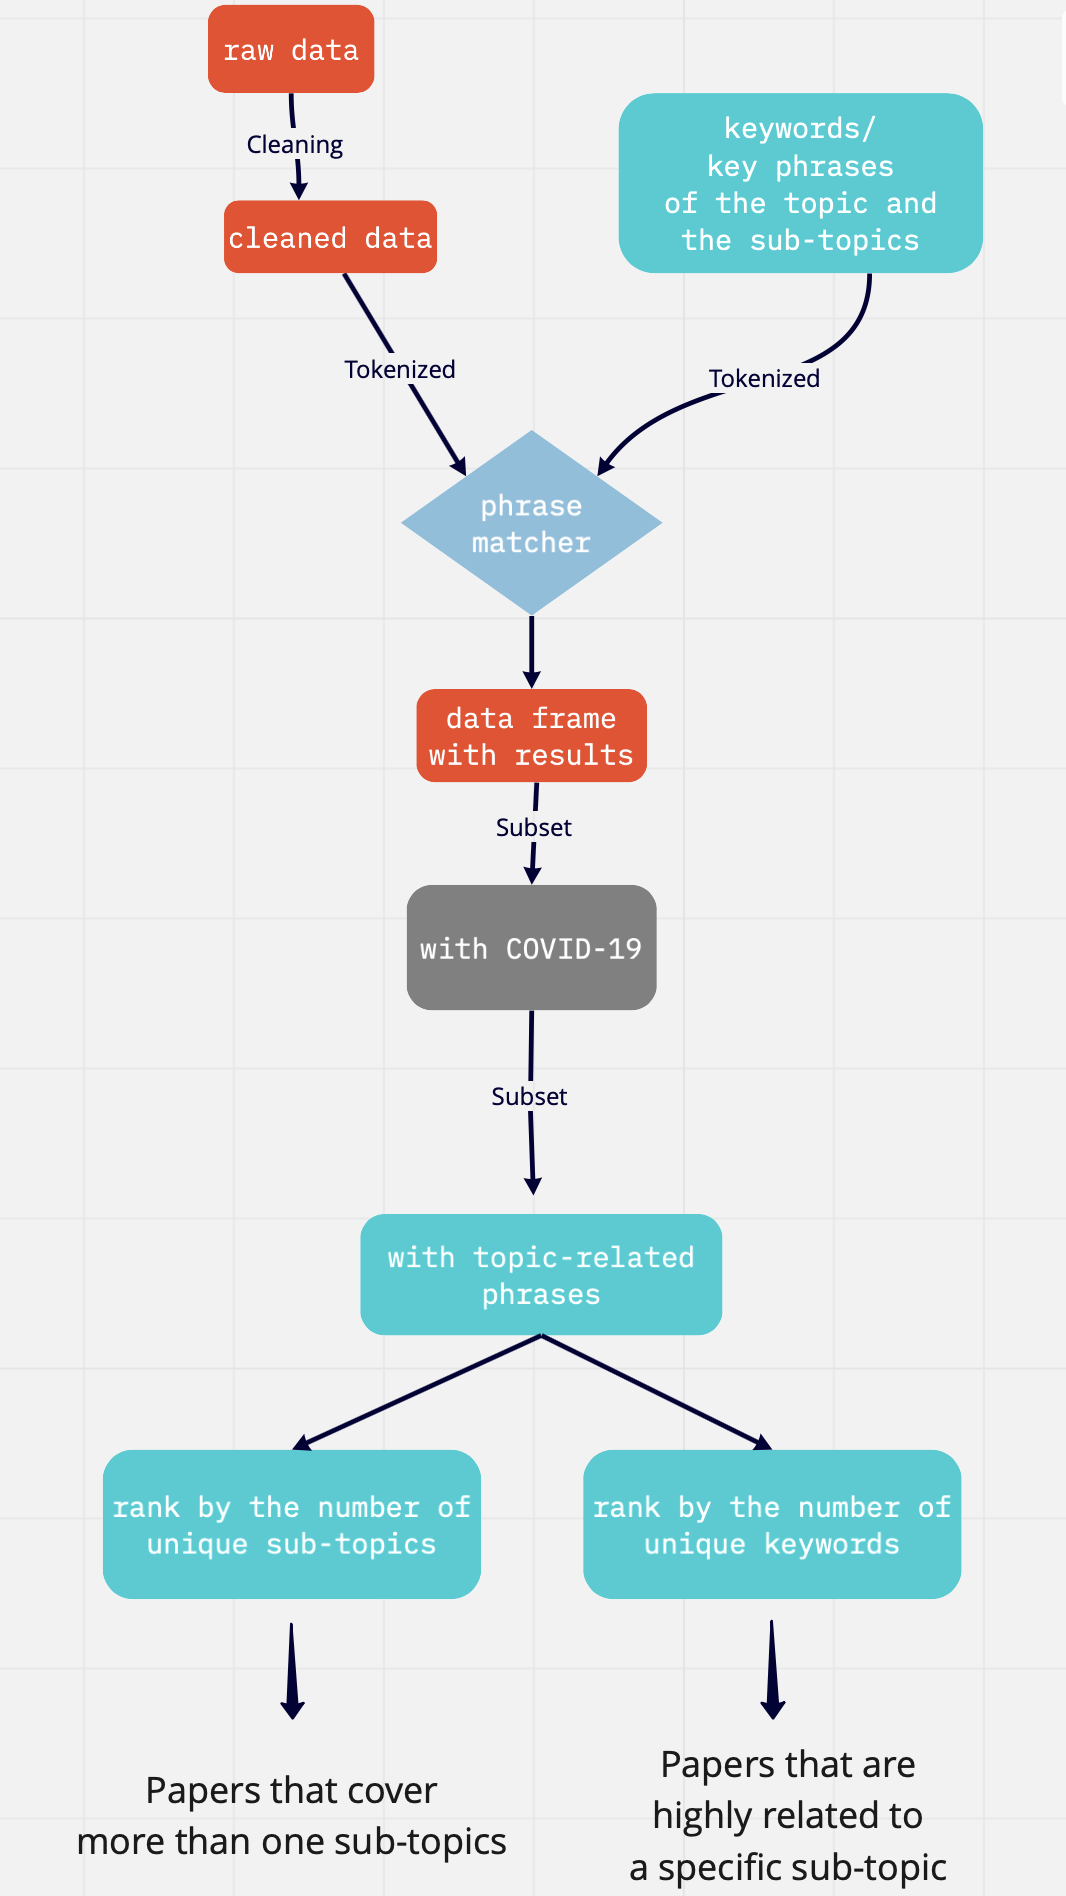

<a id="data_processing"></a>
## Data processing

In [ ]:
# load all the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# load the raw data
paper = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')

In [ ]:
# for toubleshooting if there's problem with the pre-written cleaning steps
paper.head()

In [ ]:
length_of_df = len(paper)
print(f'Before cleaning, there are {length_of_df} entries in the metadata.csv file.')

In [ ]:
# cleaning pipline
''' 1. keeping the columns: cord_uid, title, abstract
    2. remove duplication in the title column, because they may have different cord_uid, 
       and not being recognized as duplicated entry
    3. remove NA in the abstract column, because the analysis will use the words from the 
       abstract column
    4. reset the index of the dataframe'''

paper.drop(columns=['sha','source_x','doi','pmcid','pubmed_id','license', 'publish_time',
                    'authors', 'journal','Microsoft Academic Paper ID',
                    'WHO #Covidence', 'has_pdf_parse','has_pmc_xml_parse',
                    'full_text_file', 'url'], 
           inplace = True)

paper.drop_duplicates(subset=['title'], keep = 'first', inplace = True)

paper.dropna(subset = ['abstract'], inplace = True)

paper.reset_index(drop=True)

In [ ]:
length_of_df = len(paper)
print(f'After cleaning, there are {length_of_df} entries in dataframe, "paper".')

In [ ]:
# need to install en_core_sci_lg, as it is not pre-installed on Kaggle.

!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
# import the natural language processing library and PhraseMatcher
import spacy
import en_core_sci_lg
from spacy.matcher import PhraseMatcher

# load large science tokenizer, tagger, parser NER and word vectors
nlp = en_core_sci_lg.load()

# define the matcher
matcher = PhraseMatcher(nlp.vocab)

In [ ]:
Oncology_list = ['oncology', 
            'cancer',
            'biomarker',
            'turnaround time',
            'clinical lab'
           ]
covid_list = ['COVID-19',
              'novel coronavirus 2019',
              '2019 novel coronavirus',
              'new coronavirus pneumonia',
              'SARS-CoV-2',
              'coronavirus disease 2019'
             ]

# convert the phrase to a Doc object
phrase_pattern_Oncology = [nlp(text) for text in Oncology_list]
phrase_pattern_covid = [nlp(text) for text in covid_list]

# pass the phrase_pattern to the matcher
matcher.add('Oncology', None, *phrase_pattern_Oncology)
matcher.add('COVID', None, *phrase_pattern_covid)

In [ ]:
def matchID_to_matchString(match_output):
    '''this function coverts the result of Phrasematcher, match ID into the match string.
       
       input: Phrasematcher output, list of number with match ID, the location of the match
       string in the text. The function will use the first entry of each item in the list, 
       and convert it back to the string.
       
       output: a list of unqiue match string, which are the sub-topics (repeated matches are removed)
    '''
    
    match_string_list = list()
    
    for i in range(0, len(match_output)):
        match_string = nlp.vocab.strings[match_output[i][0]]
        
        if match_string not in match_string_list:
            match_string_list.append(match_string)
            
    return match_string_list


def match_all_keywords(abstract_nlp, match_ouput):
    '''this function covert the match output to individual keywords.
       
       input: tokenized abstract and the match output
       output: a list of keywords found in the abstract
    '''
    
    keywords = list()
    
    for i in range(0, len(match_ouput)):
        start_id, start_end = match_ouput[i][1], match_ouput[i][2]
        keywords.append(abstract_nlp[start_id:start_end].text)
        
    return keywords


def find_unique_keywords(all_keywords):
    '''this function find the unique keywords from the all_keywords list
    
       input: a list of all keywords
       output: a list of unique keywords
    '''
    
    unique_list = list()
    
    for words in all_keywords:
        if words not in unique_list:
            unique_list.append(words)
            
    return unique_list

def one_hot_encoding(df, col_name, topics):
    '''this function is a one_hot_encoding process to convert a list of match_string or unique_keywords into
       columns with 0/1 with the column name representing the sub-topic or keywords.
       
       input: 
             df:the dataframe that the new columns will be added
             col_name: it can be the columns match_string if sub-topic is intented to be unpacked; or 
                       unique_keywords if indivdiual keywords is intented to be unpacked
             word_list:  a list of sub-topics in match_string or a list of unique_keywords,
                        it should be each entry of the column: 'match_string' or 'unique_keywords'
       ouput: the dataframe with new column
       
    '''
    def unpack_topic(word_list, topic):
        
        is_topic = list()
        
        for item in word_list:
            is_topic.append(topic in item)
        return sum(is_topic)

    for topic in topics:
        df[topic] = df[col_name].apply(lambda x: unpack_topic(x, topic))
    
    return df

In [ ]:
# additional functions for analysis on individual keywords level

def count_keywords(unique_keywords):
    '''this function count the unique keywords of the whole dataframe'''
    
    keyword_count = dict()
    keywords_list = list()
    
    for row in unique_keywords:
        keywords_list.extend(row)
        
    for word in keywords_list:
        if word in keyword_count:
            keyword_count[word] += 1
        else:
            keyword_count[word] = 1

    return keyword_count

def remove_covid(count_list):
    for word in covid_list:
        count_list.pop(word)
    return count_list

def output_title(df, keyword):
    new_df = df.loc[df[keyword] == 1].copy()
    new_df.sort_values(by = ['no_unique_keywords'], ascending = False, inplace = True)
    return new_df.filter(items = ['cord_uid', 'title'])

In [ ]:
# tokenizer the text in abstract
paper['abstract_nlp'] = paper['abstract'].apply(lambda x: nlp(x))

In [ ]:
# match the phrases to the tokenized abstract
paper['match_output'] = paper['abstract_nlp'].apply(lambda x: matcher(x))

# convert the phrasematcher output into strings
paper['match_string'] = paper['match_output'].apply(matchID_to_matchString)

# find all the keywords/phrase in the string output of the phrasematcher
paper['all_keywords'] = paper.apply(lambda x: match_all_keywords(x['abstract_nlp'],x['match_output']), axis = 'columns')

# find the unique keywords, ie. remove duplications
paper['unique_keywords'] = paper['all_keywords'].apply(find_unique_keywords)

# count the number of topics and the number of unique keywords
paper['no_topics'] = paper['match_string'].apply(len)
paper['no_unique_keywords'] = paper['unique_keywords'].apply(len)

# remove unwanted columns
paper.drop(columns = ['abstract_nlp','match_output'], inplace = True)

In [ ]:
# one-hot-encoding to covert the data in list to individual columns
sub_topics = ['Oncology', 'COVID']
one_hot_encoding(paper, 'match_string', sub_topics)

In [ ]:
# subset the papers related to COVID-19
covid_paper = paper.loc[paper['COVID'] > 0].copy()

In [ ]:
# count number of unique keywords that is present (not counting keywords related to COVID-19)
covid_oncology_list = count_keywords(covid_paper['unique_keywords'])
covid_oncology_list = remove_covid(covid_oncology_list)
keywords_stat = pd.DataFrame.from_dict(covid_oncology_list, orient = 'index', columns = ['counts'])
keywords_stat = keywords_stat.sort_values(by = ['counts'], ascending = False)

In [ ]:
# adding each keywords to the dataframe
keywords_list = keywords_stat.index
one_hot_encoding(covid_paper, 'unique_keywords', keywords_list)

In [ ]:
# add a column with the number of ethic topics
covid_paper['oncology_topics'] = covid_paper['no_topics'].apply(lambda x: x-1)

# add a column with the number of ethic topics
covid_paper['no_oncology_keywords'] = covid_paper.apply(lambda x: sum(x[keywords_list]), axis = 1)

# sort the dataframe with the number of topic, and the number of unique keywords
covid_paper.sort_values(by = ['oncology_topics', 'no_oncology_keywords'], ascending = False, inplace = True)

# output the COVID-19 papers 
covid_paper.to_csv('covid_paper.csv')

# subset the oncology papers
oncology_paper = covid_paper.loc[covid_paper['Oncology'] > 0].copy()

# output the oncology papers
oncology_paper.to_csv('oncology_paper.csv')

In [ ]:
oncology_paper.head(n=20)

<a id="results"></a>
## Results

In [ ]:
length_of_covid = len(covid_paper)
print(f'There are {length_of_covid} research papers related to COVID-19.')

In [ ]:
length_of_oncology = len(oncology_paper)
print(f'There are {length_of_oncology} research papers related to oncology.')

<a id="visualizations"></a>
### Visualizations

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize = [10, 8])
plot4 = keywords_stat.plot(kind = 'barh',legend=False)
plot4.set_xlabel('Number of research papers')
plot4.set_ylabel('search phrases/keywords')

Cancer, oncology and biomarker are the most found keywords.

<a id="oncology"></a>
### Research papers on oncology

#### Research paper that contain the keywords, "turnaround time"

In [ ]:
pd.set_option('max_colwidth', 150)
output_title(oncology_paper,'turnaround time')

#### Research papers that contain the keyword, "biomarker"

In [ ]:
output_title(oncology_paper,'biomarker')

#### Research papers that contan the keyword, "oncology"

In [ ]:
output_title(oncology_paper,'oncology')

#### Research papers that contan the keyword, "cancer"

In [ ]:
output_title(oncology_paper,'cancer')